Plot to compute the first level maps 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
import os
import regex as re
from tqdm import tqdm
from nilearn import image, plotting, glm
from joblib import Parallel, delayed
from joblib import dump, load

In [205]:
pipeline_1 = "rot_[x-z]$|trans_[x-z]$"
pipeline_2 = "rot|trans"
pipeline_3 = "rot_[x-z]$|trans_[x-z]$|a_comp_cor_0[0-6]"
pipeline_4 = "rot|trans|a_comp_cor_0[0-6]"
pipeline_5 = "motion"
pipeline_6 = "rot|trans|csf$|white_matter$"

In [3]:
filename = "../task-stroop/confounders/sub-1003_ses-01_task-stroop_desc-confounds_regressors.tsv"
print(pd.read_csv(filename, sep="\t").filter(regex=pipeline_1).head(1))
print("")
print(pd.read_csv(filename, sep="\t").filter(regex=pipeline_2).head(1))
print("")
print(pd.read_csv(filename, sep="\t").filter(regex=pipeline_3).head(1))
print("")
print(pd.read_csv(filename, sep="\t").filter(regex=pipeline_4).head(1))
print("")
print(pd.read_csv(filename, sep="\t").filter(regex=pipeline_5).head(1))

    trans_x   trans_y   trans_z     rot_x     rot_y     rot_z
0  0.048045 -0.060039 -0.036422 -0.002235  0.000081 -0.001531

    trans_x  trans_x_derivative1  trans_x_power2  trans_x_derivative1_power2  \
0  0.048045                  NaN        0.002308                         NaN   

    trans_y  trans_y_derivative1  trans_y_derivative1_power2  trans_y_power2  \
0 -0.060039                  NaN                         NaN        0.003605   

    trans_z  trans_z_derivative1  ...  rot_x_power2  rot_x_derivative1_power2  \
0 -0.036422                  NaN  ...      0.000005                       NaN   

      rot_y  rot_y_derivative1  rot_y_power2  rot_y_derivative1_power2  \
0  0.000081                NaN  6.604309e-09                       NaN   

      rot_z  rot_z_derivative1  rot_z_power2  rot_z_derivative1_power2  
0 -0.001531                NaN      0.000002                       NaN  

[1 rows x 24 columns]

   a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  a_comp_cor_03  a_comp_c

In [4]:
first_level_opts = {"smoothing_fwhm" : 6.0,
                    "t_r" : 2.0,
                    "hrf_model" : "glover + derivative + dispersion",
                    "high_pass": 1/187.,
                    "drift_model" : 'cosine'
                   }

In [5]:
contrast = 'Incongruent-Congruent'

In [6]:
def compute_first_level(run_img, event_file, confound_df, opts_dict):
    fmri_glm = glm.first_level.FirstLevelModel(**opts_dict)
    fmri_glm.fit(run_imgs=run_img, events=event_file, confounds=confound_df)
    return fmri_glm

# STROOP

In [7]:
# extract subjects with stroop data
subjects_used = np.loadtxt("../data/subjects_intersect_motion_035.txt")
len(subjects_used)

261

Load preproc images and their confounder files

In [11]:
conf_files = ["../task-stroop/confounders/sub-%d_ses-01_task-stroop_desc-confounds_regressors.tsv" % subj \
            for subj in subjects_stroop]
conf_files_df = [pd.read_csv(file, sep="\t") for file in conf_files]
# Mean fwd 
fwd = np.array([df.framewise_displacement.dropna().mean() for df in conf_files_df])

stroop_event_file = "../data/task-stroop_events.tsv"

In [183]:
run_imgs = ["../task-stroop/preproc/sub-%d_ses-01_task-stroop_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % subj \
            for subj in subjects_used]
conf_files = ["../task-stroop/confounders/sub-%d_ses-01_task-stroop_desc-confounds_regressors.tsv" % subj \
            for subj in subjects_used]
conf_files_df = [pd.read_csv(file, sep="\t").fillna(0) for file in conf_files]
fwd = np.array([df.framewise_displacement.dropna().mean() for df in conf_files_df])
stroop_event_file = "../data/task-stroop_events.tsv"

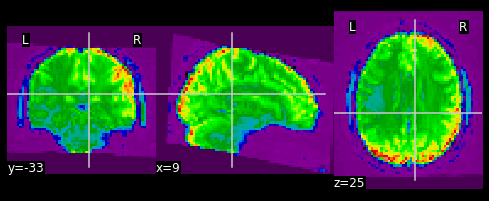

In [33]:
plotting.plot_epi(image.mean_img(run_imgs[10]))

In [12]:
len(conf_files_df)

261

In [13]:
first_dict_pipelines = dict()
for (name, pipe) in zip(["6MP", "24MP", "6MP_ACOR", "24MP_ACOR", "Censoring"], 
                        [pipeline_1, pipeline_2, pipeline_3, pipeline_4, pipeline_5]):
    
    print("doing pipeline %s" % name)
    
    confounder_pipeline_df = [df.filter(regex=pipe) for df in conf_files_df]
    
    list_first_stroop = Parallel(n_jobs=10)(delayed(compute_first_level)(run_img, 
                                                                     stroop_event_file, 
                                                                     conf_df, 
                                                                     first_level_opts) \
                                            for (run_img, conf_df) \
                                            in tqdm(zip(run_imgs, confounder_pipeline_df), leave=0))
    
    first_dict_pipelines[name] = list_first_stroop

0it [00:00, ?it/s]

doing pipeline 6MP


0it [00:00, ?it/s]      

doing pipeline 24MP


0it [00:00, ?it/s]      

doing pipeline 6MP_ACOR


0it [00:00, ?it/s]      

doing pipeline 24MP_ACOR


0it [00:00, ?it/s]      

doing pipeline Censoring


In [208]:
for (name, pipe) in zip(["6MP_WMCSF"], 
                        [pipeline_6]):
    
    print("doing pipeline %s" % name)
    
    confounder_pipeline_df = [df.filter(regex=pipe) for df in conf_files_df]
    
    list_first_stroop = Parallel(n_jobs=10)(delayed(compute_first_level)(run_img, 
                                                                     stroop_event_file, 
                                                                     conf_df, 
                                                                     first_level_opts) \
                                            for (run_img, conf_df) \
                                            in tqdm(zip(run_imgs, confounder_pipeline_df), leave=0))
    
    first_dict_pipelines[name] = list_first_stroop

0it [00:00, ?it/s]

doing pipeline 6MP_WMCSF


30it [00:24,  1.51it/s]/home/javi/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [14]:
from nilearn.glm.second_level import SecondLevelModel
second_level = SecondLevelModel()

second_level_fit = second_level.fit(first_dict_pipelines["6MP"])
second_level_pip_1 = second_level_fit.compute_contrast(first_level_contrast='Incongruent-Congruent', 
                                                               output_type="all")

second_level_fit = second_level.fit(first_dict_pipelines["24MP"])
second_level_pip_2 = second_level_fit.compute_contrast(first_level_contrast='Incongruent-Congruent', 
                                                               output_type="all")

second_level_fit = second_level.fit(first_dict_pipelines["6MP_ACOR"])
second_level_pip_3 = second_level_fit.compute_contrast(first_level_contrast='Incongruent-Congruent', 
                                                               output_type="all")

second_level_fit = second_level.fit(first_dict_pipelines["24MP_ACOR"])
second_level_pip_4 = second_level_fit.compute_contrast(first_level_contrast='Incongruent-Congruent', 
                                                               output_type="all")

second_level_fit = second_level.fit(first_dict_pipelines["Censoring"])
second_level_pip_5 = second_level_fit.compute_contrast(first_level_contrast='Incongruent-Congruent', 
                                                               output_type="all")


In [209]:
second_level_fit = second_level.fit(first_dict_pipelines["6MP_WMCSF"])
second_level_pip_6 = second_level_fit.compute_contrast(first_level_contrast='Incongruent-Congruent', 
                                                               output_type="all")


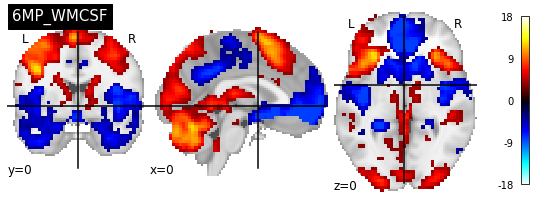

In [210]:
# This is not 6MP, but 25
plotting.plot_stat_map(glm.threshold_stats_img(second_level_pip_6['z_score'])[0], title="6MP_WMCSF", cut_coords=(0,0,0), vmax=18)

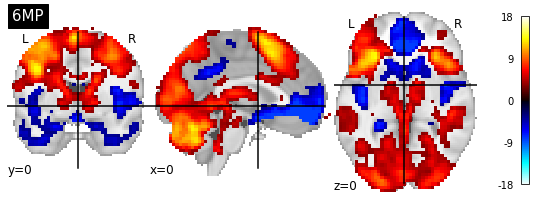

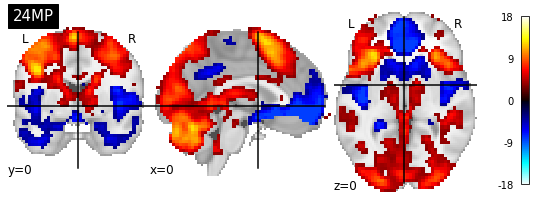

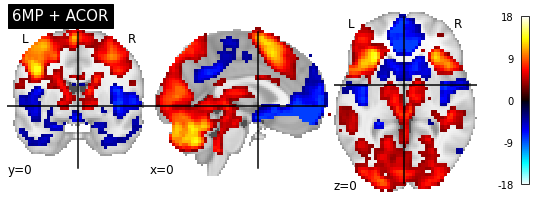

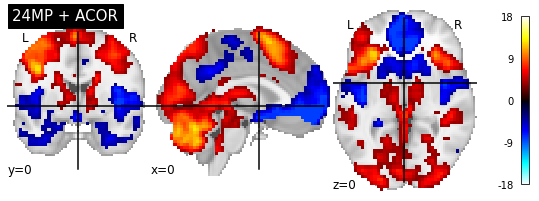

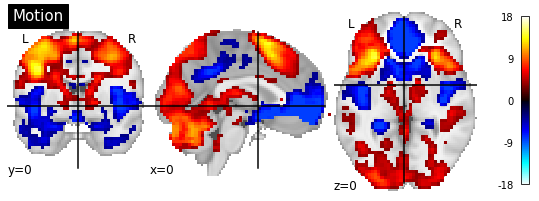

In [15]:
plotting.plot_stat_map(glm.threshold_stats_img(second_level_pip_1['z_score'])[0], title="6MP", cut_coords=(0,0,0), vmax=18)
plotting.plot_stat_map(glm.threshold_stats_img(second_level_pip_2['z_score'])[0], title="24MP", cut_coords=(0,0,0), vmax=18)
plotting.plot_stat_map(glm.threshold_stats_img(second_level_pip_3['z_score'])[0], title="6MP + ACOR", cut_coords=(0,0,0), vmax=18)
plotting.plot_stat_map(glm.threshold_stats_img(second_level_pip_4['z_score'])[0], title="24MP + ACOR", cut_coords=(0,0,0), vmax=18)
plotting.plot_stat_map(glm.threshold_stats_img(second_level_pip_5['z_score'])[0], title="Motion", cut_coords=(0,0,0), vmax=18)

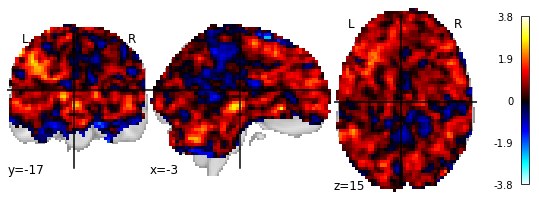

In [16]:
plotting.plot_stat_map(image.math_img("img1-img2", 
                                      img1=second_level_pip_1['stat'], 
                                      img2=second_level_pip_2['stat']))

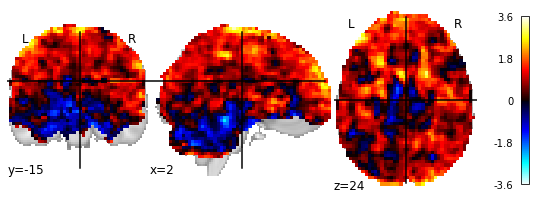

In [17]:
plotting.plot_stat_map(image.math_img("img1-img2", 
                                      img1=second_level_pip_1['stat'], 
                                      img2=second_level_pip_3['stat']))

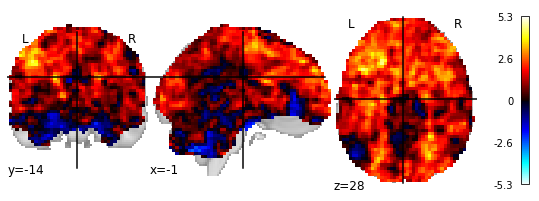

In [18]:
plotting.plot_stat_map(image.math_img("img1-img2", 
                                      img1=second_level_pip_1['stat'], 
                                      img2=second_level_pip_4['stat']))

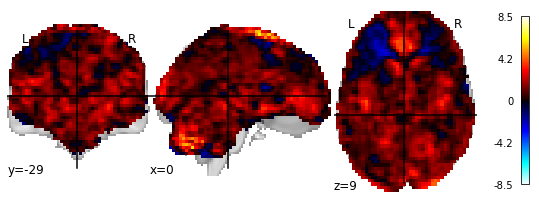

In [19]:
plotting.plot_stat_map(image.math_img("img1-img2", 
                                      img1=second_level_pip_1['stat'], 
                                      img2=second_level_pip_5['stat']))

261it [01:47,  2.43it/s]
/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:786: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


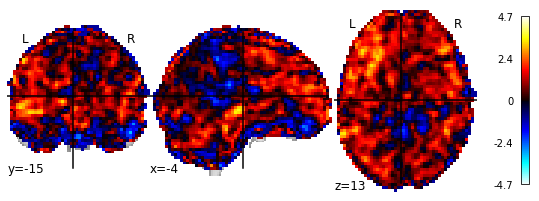

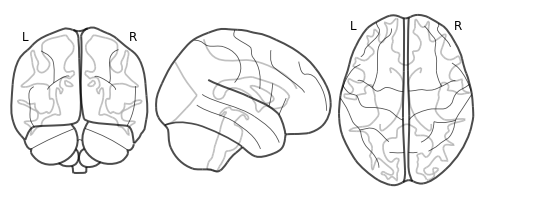

In [20]:
diff_ef = []
for first_pip_1, first_pip_2 in tqdm(zip(first_dict_pipelines["6MP"], first_dict_pipelines["24MP"])):
    img1 = first_pip_1.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    img2 = first_pip_2.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    
    # Take the difference image
    diff_ef.append(image.math_img("img1-img2", img1=img1, img2=img2))

second_level_fit = second_level.fit(diff_ef, design_matrix=pd.DataFrame({'constant': [1]*len(diff_ef)}))

plotting.plot_stat_map(second_level_fit.compute_contrast('constant', output_type="stat"))

plotting.plot_glass_brain(glm.threshold_stats_img(second_level_fit.compute_contrast('constant', output_type="stat"), 
                                                  alpha=0.05, height_control='fdr')[0], 
                          plot_abs=False, 
                          colorbar=True, 
                          cmap=plotting.cm.cold_hot)

261it [01:57,  2.22it/s]


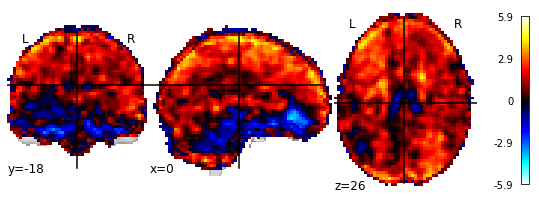

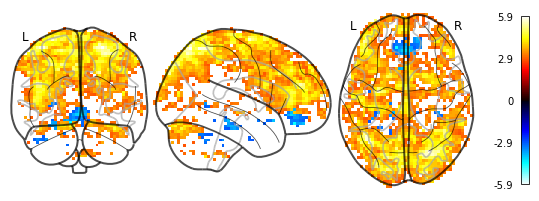

In [21]:
diff_ef = []
for first_pip_1, first_pip_2 in tqdm(zip(first_dict_pipelines["6MP"], first_dict_pipelines["6MP_ACOR"])):
    img1 = first_pip_1.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    img2 = first_pip_2.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    
    # Take the difference image
    diff_ef.append(image.math_img("img1-img2", img1=img1, img2=img2))

second_level_fit = second_level.fit(diff_ef, design_matrix=pd.DataFrame({'constant': [1]*len(diff_ef)}))

plotting.plot_stat_map(second_level_fit.compute_contrast('constant', output_type="stat"))

plotting.plot_glass_brain(glm.threshold_stats_img(second_level_fit.compute_contrast('constant', output_type="stat"), 
                                                  alpha=0.05, height_control='fdr')[0], 
                          plot_abs=False, 
                          colorbar=True, 
                          cmap=plotting.cm.cold_hot)

261it [02:08,  2.03it/s]


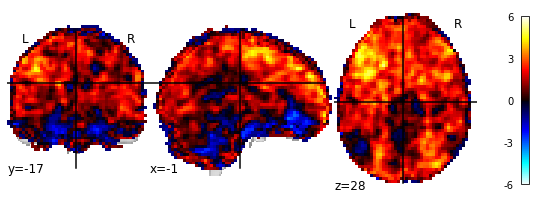

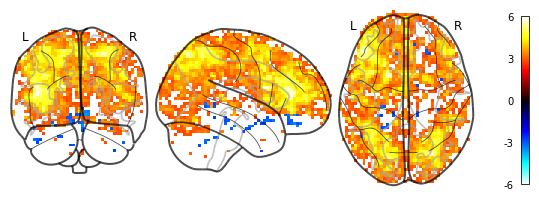

In [22]:
diff_ef = []
for first_pip_1, first_pip_2 in tqdm(zip(first_dict_pipelines["6MP"], first_dict_pipelines["24MP_ACOR"])):
    img1 = first_pip_1.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    img2 = first_pip_2.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    
    # Take the difference image
    diff_ef.append(image.math_img("img1-img2", img1=img1, img2=img2))

second_level_fit = second_level.fit(diff_ef, design_matrix=pd.DataFrame({'constant': [1]*len(diff_ef)}))

plotting.plot_stat_map(second_level_fit.compute_contrast('constant', output_type="stat"))

plotting.plot_glass_brain(glm.threshold_stats_img(second_level_fit.compute_contrast('constant', output_type="stat"), 
                                                  alpha=0.05, height_control='fdr')[0], 
                          plot_abs=False, 
                          colorbar=True, 
                          cmap=plotting.cm.cold_hot)

261it [02:22,  1.84it/s]


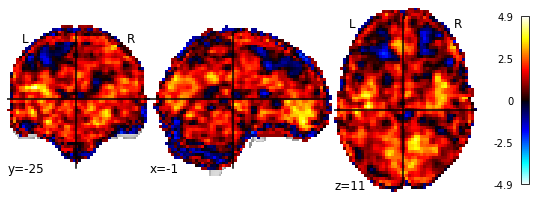

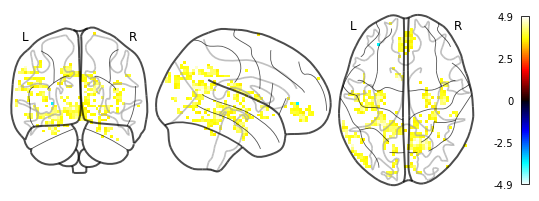

In [23]:
diff_ef = []
for first_pip_1, first_pip_2 in tqdm(zip(first_dict_pipelines["6MP"], first_dict_pipelines["Censoring"])):
    img1 = first_pip_1.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    img2 = first_pip_2.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    
    # Take the difference image
    diff_ef.append(image.math_img("img1-img2", img1=img1, img2=img2))

second_level_fit = second_level.fit(diff_ef, design_matrix=pd.DataFrame({'constant': [1]*len(diff_ef)}))

plotting.plot_stat_map(second_level_fit.compute_contrast('constant', output_type="stat"))

plotting.plot_glass_brain(glm.threshold_stats_img(second_level_fit.compute_contrast('constant', output_type="stat"), 
                                                  alpha=0.05, height_control='fdr')[0], 
                          plot_abs=False, 
                          colorbar=True, 
                          cmap=plotting.cm.cold_hot)

Ok, so let's try to predict something with these things (SBP reactivity)

(array([ 1.,  0.,  0., 15., 41., 91., 71., 28.,  8.,  6.]),
 array([-24.33333333, -19.275     , -14.21666667,  -9.15833333,
         -4.1       ,   0.95833333,   6.01666667,  11.075     ,
         16.13333333,  21.19166667,  26.25      ]),
 <BarContainer object of 10 artists>)

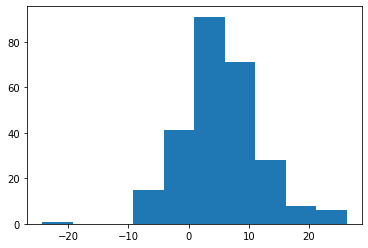

In [25]:
y = pd.merge(pd.DataFrame({'id': subjects_used}), 
             pd.read_csv("../data/pip_reactivity_2020.csv"), 
             on="id").sbp_reactivity_stroop
plt.hist(y)

In [42]:
from nilearn import masking 
gm_mask = "../data/grey_mask_motion_035.nii.gz"

In [128]:
[img for img in list_gm_segs if os.path.exists(img) is False]

['../segmentation/bold_res/sub-2101_space-MNI152NLin2009cAsym_desc-GM_probseg.nii.gz',
 '../segmentation/bold_res/sub-2107_space-MNI152NLin2009cAsym_desc-GM_probseg.nii.gz']

In [55]:
X_dict = {}
for pipe in tqdm(first_dict_pipelines.keys()):
    X = []
    for first_model in first_dict_pipelines[pipe]:
        con_img = first_model.compute_contrast('Incongruent-Congruent', output_type="effect_size")
        X.append(masking.apply_mask(con_img, gm_mask))
    X = np.row_stack(X)
    X_dict[pipe] = X

100%|██████████| 5/5 [07:15<00:00, 87.01s/it]


In [212]:
X = []
for first_model in first_dict_pipelines["6MP_WMCSF"]:
    con_img = first_model.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    X.append(masking.apply_mask(con_img, gm_mask))
X = np.row_stack(X)
X_dict["6MP_WMCSF"] = X

In [78]:
from my_sklearn_tools.pca_regressors import PCARegression, PCARegressionCV
from my_sklearn_tools.model_selection import StratifiedKFoldReg
from sklearn.model_selection import cross_val_score

lasso_pcr = PCARegression().build('lasso')
lasso_pcr_cv = PCARegressionCV().build('lasso')
cv = StratifiedKFoldReg(n_splits=10, shuffle=True, random_state=0)

In [76]:
for key in tqdm(X_dict.keys()):
    X = X_dict[key]
    r2 = cross_val_score(lasso_pcr, X, y, cv=cv).mean()
    print("case: %s, R2=%.3f" % (key, r2))

 20%|██        | 1/5 [00:08<00:33,  8.48s/it]

case: 6MP, R2=-0.038


 40%|████      | 2/5 [00:16<00:25,  8.46s/it]

case: 24MP, R2=0.075


 60%|██████    | 3/5 [00:25<00:16,  8.46s/it]

case: 6MP_ACOR, R2=-0.100


 80%|████████  | 4/5 [00:33<00:08,  8.45s/it]

case: 24MP_ACOR, R2=0.052


100%|██████████| 5/5 [00:42<00:00,  8.45s/it]

case: Censoring, R2=0.047


In [ ]:
r2 = cross_val_score(lasso_pcr_cv, X, y, cv=cv).mean()
print("case: %s, R2=%.3f" % (key, r2))

In [86]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_validate

In [211]:
cv_inner = StratifiedKFoldReg(n_splits=10, random_state=0, shuffle=True)
cv_outer = StratifiedKFoldReg(n_splits=10, shuffle=True, random_state=0)
lasso_pcr_cv = PCARegressionCV(cv=cv_inner, n_jobs=-1, verbose=0).build('lasso')
lasso_pcr_cv.set_params(**{'scoring':'r2'})
#res_cv = cross_validate(lasso_pcr_cv, X_dict["6MP"], y, cv=cv_outer, return_train_score=True, return_estimator=True)

GridSearchCV(cv=StratifiedKFoldReg(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(memory=Memory(location=/tmp/tmp0opyys7i/joblib),
                                steps=[('variancethreshold',
                                        VarianceThreshold()),
                                       ('pca', PCA()),
                                       ('lasso', Lasso(max_iter=1000000.0))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
       1....
       4.03701726e+00, 4.64158883e+00, 5.33669923e+00, 6.13590727e+00,
       7.05480231e+00, 8.11130831e+00, 9.32603347e+00, 1.07226722e+01,
       1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
       2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
       3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
       6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02])},
     

In [213]:
y_pred =  cross_val_predict(lasso_pcr_cv, X_dict["6MP_WMCSF"], y, cv=cv_outer)#, return_train_score=True, return_estimator=True)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(VarianceThreshold(), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), 0       3.416667
1       6.583333
2       3.750000
3       4.666667
4      17.750000
         ...    
253    -6.416667
255     5.500000
256    11.666667
259    10.000000
260     0.250000
Name: sbp_reactivity_stroop, Length: 234, dtype: float64, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), 0       3.416667
1       6.583333
2       3.750000
3       4.666667
4      17.750000
         ...    
253    -6.416667
255     5.500000
256    11.666667
259    10.000000

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


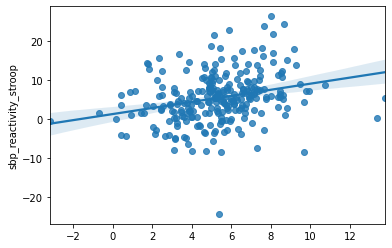

In [214]:
import seaborn as sns
sns.regplot(y_pred, y)
pass

In [218]:
np.corrcoef(y, y_pred)

array([[1.        , 0.26868392],
       [0.26868392, 1.        ]])

In [216]:
np.corrcoef(y_pred, fwd)

array([[1.       , 0.0316678],
       [0.0316678, 1.       ]])

In [217]:
from sklearn.metrics import r2_score
r2_score(y, y_pred)

0.06619740183222944

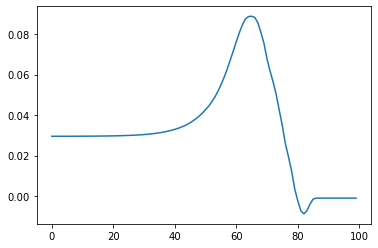

In [174]:
plt.plot(res_cv['estimator'][7].cv_results_['mean_test_score'])

In [131]:
[sum(abs(estim.named_steps['lassocv'].coef_)>0) for estim in res_cv['estimator']]

[13, 8, 25, 7, 4, 4, 5, 33, 17, 18]

In [133]:
res_cv['test_score'].mean()

0.017020584365165015

(35.0, 50.0)

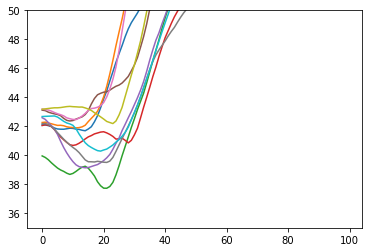

In [138]:
for estim in res_cv['estimator']:
    plt.plot(np.mean(estim.named_steps['lassocv'].mse_path_, axis=1))
plt.ylim([35,50])

In [71]:
from sklearn.model_selection import cross_val_predict

for key in tqdm(X_dict.keys()):
    X = X_dict[key]
    y_pred = cross_val_predict(lasso_pcr, X, y, cv=cv)
    print("case: %s, Pearson r = %.3f" % (key, np.corrcoef(y, y_pred)[0,1]))

 20%|██        | 1/5 [00:08<00:34,  8.74s/it]

case: 6MP, Pearson r =0.169


 40%|████      | 2/5 [00:17<00:25,  8.65s/it]

case: 24MP, Pearson r =0.304


 60%|██████    | 3/5 [00:25<00:17,  8.59s/it]

case: 6MP_ACOR, Pearson r =0.127


 80%|████████  | 4/5 [00:34<00:08,  8.55s/it]

case: 24MP_ACOR, Pearson r =0.284


100%|██████████| 5/5 [00:42<00:00,  8.51s/it]

case: Censoring, Pearson r =0.255


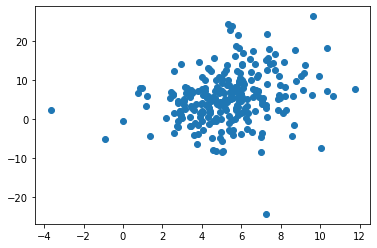

In [72]:
plt.scatter(y_pred, y)

In [46]:
X = []
for first_model in tqdm(first_dict_pipelines['Censoring']):
    con_iamg = first_model.compute_contrast('Incongruent-Congruent', output_type="effect_size")
    X.append(masking.apply_mask(con_img, gm_mask))
X = np.row_stack(X)
X_dict[pipe] = X

100%|██████████| 261/261 [01:29<00:00,  2.91it/s]


NameError: name 'X_dict' is not defined

In [74]:
#"../task-stroop/preproc/sub-3250"

In [44]:
first_dict_pipelines.keys()

dict_keys(['6MP', '24MP', '6MP_ACOR', '24MP_ACOR', 'Censoring'])